# Previsão de séries temporais com NeuralProphet em Python

## Bibliotecas e Configurações

In [ ]:
!pip install neuralprophet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralprophet import NeuralProphet

from sklearn.metrics import mean_absolute_error

In [ ]:
from neuralprophet import set_random_seed 
set_random_seed(0)

In [ ]:
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif','fontname': 'Times New Roman'})

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  if np.any(y_true==0)==True:
    print('Erro: y_true contêm zeros!')
    return np.inf
  else:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Importar e visualizar dados (série temporal)

In [ ]:
# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)

df.columns = ['ds', 'y']
df['ds']=pd.to_datetime(df['ds'])

print(df.head(2))
print(df.tail(2))
print()
df.info()

          ds     y
0 1960-01-01  6550
1 1960-02-01  8728
            ds      y
106 1968-11-01  17180
107 1968-12-01  14577

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      108 non-null    datetime64[ns]
 1   y       108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


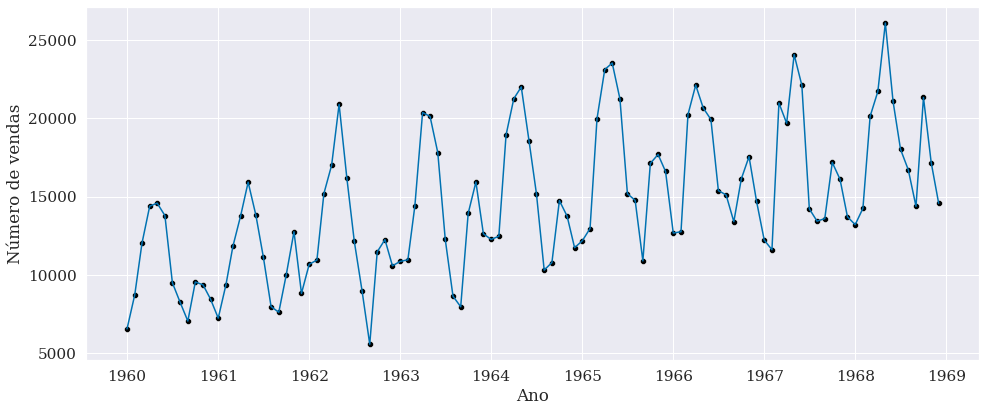

In [ ]:
#df.plot(figsize=(10,5), style='.-'); plt.show()

plt.figure(figsize=(16,6.5))
Xlabel='Ano'; Ylabel='Número de vendas'

sns.scatterplot(data=df, x='ds', y='y', color='black')
sns.lineplot(data=df, x='ds', y='y', linewidth=1.5, color='#0072B2', label='')

#plt.legend(loc='lower right')
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)
plt.show()

## Modelo de previsão

In [ ]:
#Separar dados de treino e teste:
N=12; Freq='MS'
train = df.drop(df.index[-N:])
test  = df.loc[df.index[-N:]]

print(train.shape, test.shape)
print(train.tail(1),'\n',test.head(1))

(96, 2) (12, 2)
           ds      y
95 1967-12-01  13713 
            ds      y
96 1968-01-01  13210


In [ ]:
%%time
#model = NeuralProphet()

model = NeuralProphet(
    growth="linear",    # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None,  # list of dates that may include change points (None->automatic)
    n_changepoints=15,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=0,
    d_hidden=None,      # Dimension of hidden layers of AR-Net
    ar_sparsity=None,   # Sparcity in the AR coefficients
    learning_rate=None,
    epochs=50,
    loss_func="Huber",
    normalize="auto",   # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True
)

CPU times: user 2.96 ms, sys: 0 ns, total: 2.96 ms
Wall time: 2.96 ms


In [ ]:
metrics = model.fit(train, validate_each_epoch=True, freq=Freq) 

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-02
Epoch[50/50]: 100%|██████████| 50/50 [00:02<00:00, 20.90it/s, SmoothL1Loss=0.00204, MAE=974, RegLoss=0, MAE_val=1.29e+3, SmoothL1Loss_val=0.00372]


In [ ]:
future = model.make_future_dataframe(train, periods=len(test), n_historic_predictions=len(train)) 
forecast = model.predict(future)

In [ ]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly
0,1960-01-01,6550,5795.580566,-754.419,8379.466797,-2583.885986
1,1960-02-01,8728,6323.050781,-2404.95,8624.350586,-2301.299561
2,1960-03-01,12026,11470.472656,-555.527,8853.435547,2617.037354
3,1960-04-01,14395,14658.591797,263.592,9098.319336,5560.272461
4,1960-05-01,14587,15240.412109,653.412,9320.103516,5920.307129
...,...,...,...,...,...,...
103,1968-08-01,None,14932.833984,None,18288.347656,-3355.514160
104,1968-09-01,None,13093.102539,None,18344.199219,-5251.096191
105,1968-10-01,None,17815.242188,None,18398.246094,-583.005737
106,1968-11-01,None,18206.324219,None,18454.097656,-247.774292


## Resultados

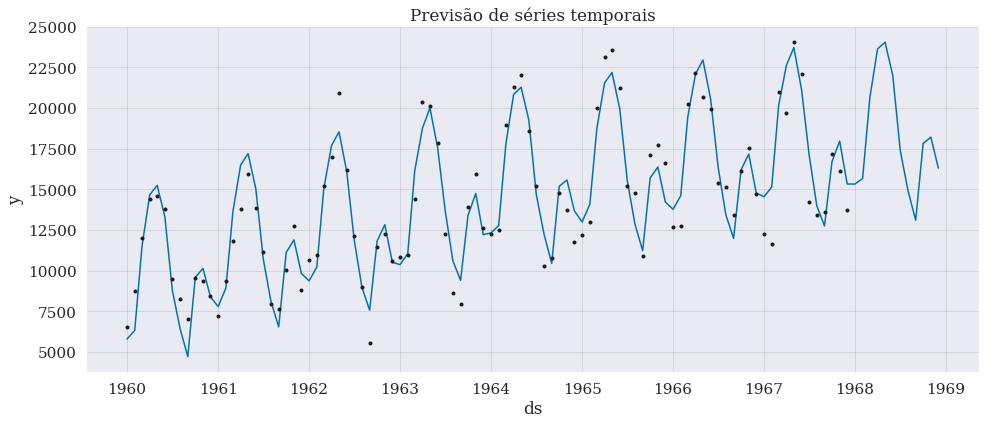

In [ ]:
model.plot(forecast,figsize=(14,6))
plt.title('Previsão de séries temporais')
plt.show()

## Avaliando o erro:

In [ ]:
y_true = test['y'].values
y_pred = forecast['yhat1'][-12:].values
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f'MAE:  {mae:.2f} vendas')
print(f'MAPE: {mape:.2f}%')

MAE:  1573.54 vendas
MAPE: 8.90%


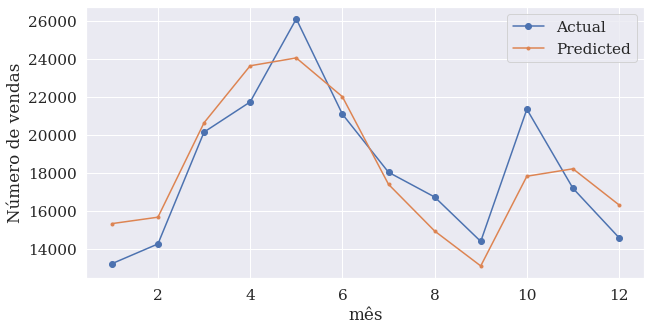

In [ ]:
# plot expected vs actual
plt.figure(figsize=(10,5))
x=np.arange(1,len(y_true)+1,1)
plt.plot(x,y_true,'o-', label='Actual')
plt.plot(x,y_pred,'.-', label='Predicted')
#Ylabel='Número de vendas'
plt.ylabel(Ylabel)
plt.xlabel('mês')
plt.legend()
plt.show()

_________________
_________________

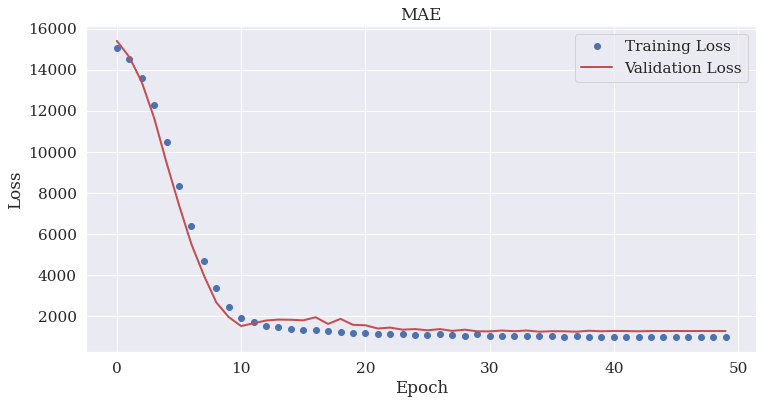

In [ ]:
plt.subplots(figsize=(12, 6))
plt.plot(metrics['MAE'], 'ob', linewidth=6, label="Training Loss")  
plt.plot(metrics['MAE_val'], '-r', linewidth=2, label="Validation Loss")
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html

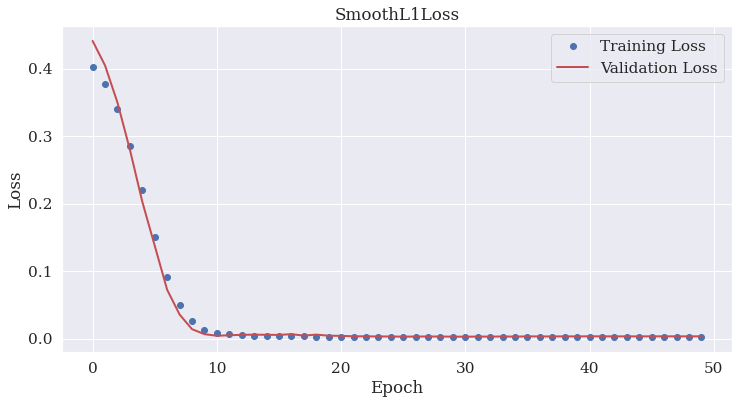

In [ ]:
plt.subplots(figsize=(12, 6))
plt.plot(metrics['SmoothL1Loss'], 'ob', linewidth=6, label="Training Loss")  
plt.plot(metrics['SmoothL1Loss_val'], '-r', linewidth=2, label="Validation Loss")
plt.title('SmoothL1Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Componentes da previsão:
Tendência e sazonalidade anual da série temporal

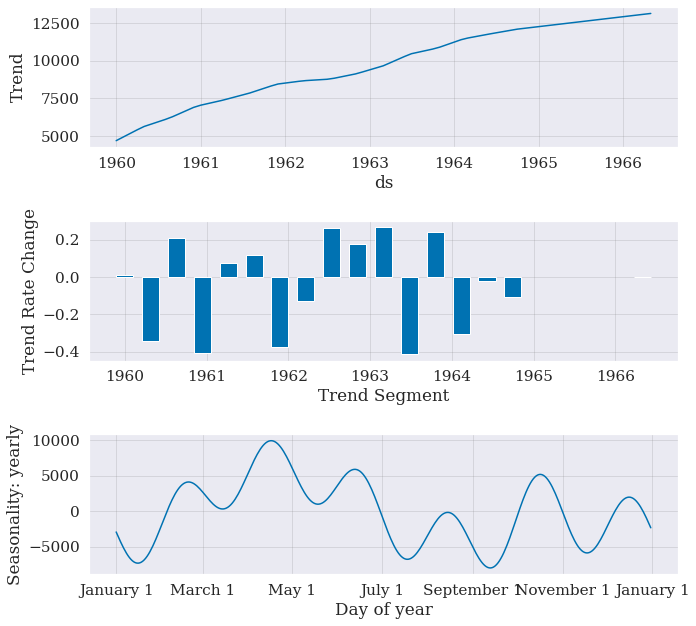

In [ ]:
model.plot_parameters()
plt.show()

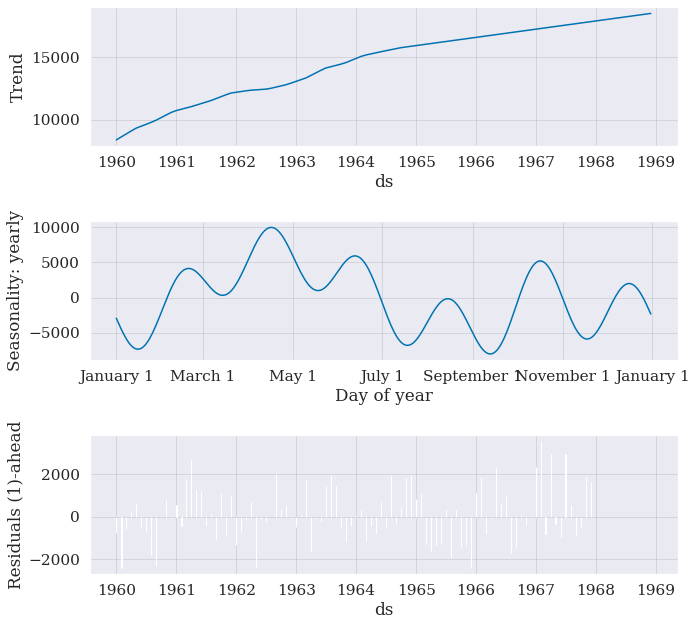

In [ ]:
model.plot_components(forecast, residuals=True)
plt.show()

_________________
_________________